# The scSpecies workflow

This tutorial demonstrates how to apply the scSpecies workflow to align three scRNA-seq datasets (mice, humans and hamsters).  

We start by loading the preprocesed `.h5mu` file saved within the `data_prepocessing.ipynb` notebook.

In [3]:
import os
import muon as mu

mu.set_options(pull_on_update=False)
#os.environ["TORCHDYNAMO_DISABLE"] = "1"

%load_ext autoreload
%autoreload 2

path = os.path.abspath('').replace('\\', '/')+'/'
mdata = mu.read_h5mu(path+'data/liver_atlas.h5mu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Before we pre-train scSpecies, we plot a UMAP representation of the unaligned mouse/human dataset pair on the data-level. 

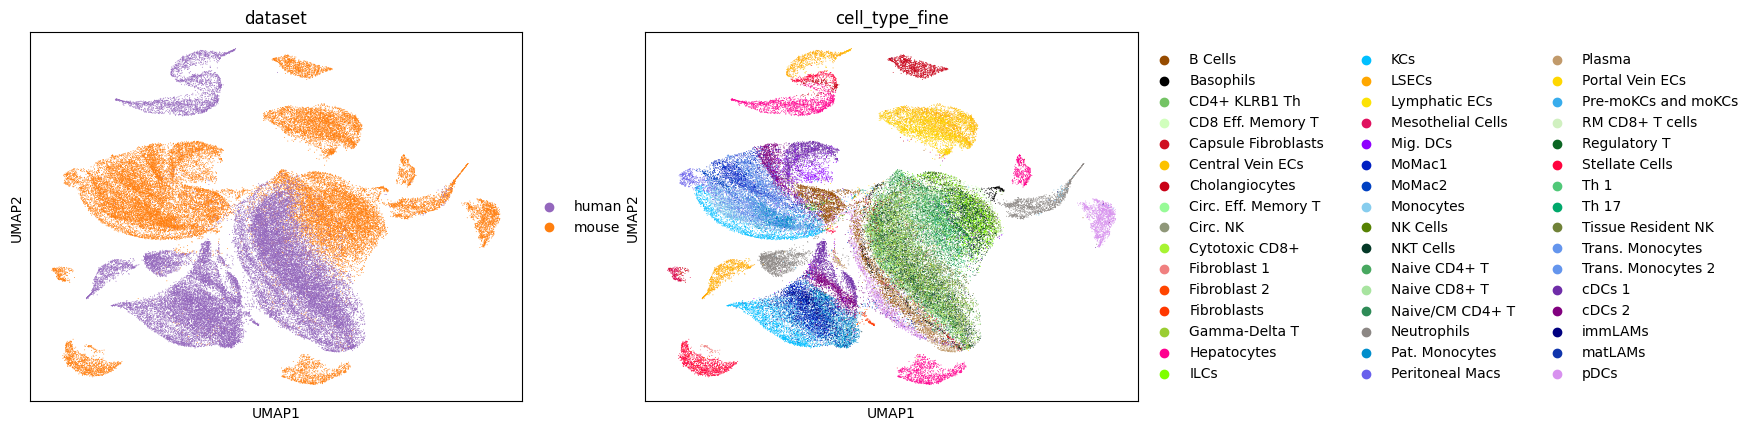

In [ ]:
from scipy import sparse
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np

from scspecies.plot import return_palette
from scspecies.models import neighbors_workaround

# Subsetting to homologous genes
_, hom_ind_mouse, hom_ind_human = np.intersect1d(mdata.mod['mouse'].var_names, mdata.mod['human'].var['var_names_transl'], return_indices=True)

adata_concat = ad.AnnData(
    X=sparse.vstack([mdata.mod['mouse'][:, hom_ind_mouse].X, mdata.mod['human'][:, hom_ind_human].X]).toarray(),
    obs=pd.concat([mdata.mod['mouse'].obs, mdata.mod['human'].obs])
).copy()

# Color scheme for the liver cell dataset. Won't return nice results for other datasets.
palette = return_palette(list(adata_concat.obs.cell_type_fine.unique()) + list(adata_concat.obs.dataset.unique()))

sc.pp.pca(adata_concat) 

# sc.pp.neighbors might crash the kernel for M1/M2 chips and use a workaroung for this function
#sc.pp.neighbors(adata_concat, use_rep='X_pca')
neighbors_workaround(adata_concat, use_rep='X_pca')

sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['dataset', 'cell_type_fine'], palette=palette)

## 1) Context and target dataset alignment

We start by aligning the mouse and human scRNA-seq datasets using scSpecies.  
We use the mouse dataset as context for the human target dataset.  
We define the corresponding context and target scVI models by instantiating the `scSpecies` class.   

In [ ]:
from scspecies.models import scSpecies
import torch

device = ("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")

model = scSpecies(device, 
                mdata, 
                path,
                context_key = 'mouse', 
                target_key = 'human',
                random_seed=1234                          
                )
                

Initializing context scVI model.
Initializing target scVI model.


First, we pre-train context scVI model with `train_context` for 30 epochs and save the model parameters to path.  
Afterwards, we calculate latent and intermediate representations with `get_representation` an save them in the context modality in the `.obsm` layer.  
Intermediate representations are also saved and later used during fine-tuning for alignment.

In [15]:
model.train_context(30, save_key='_mouse')
model.get_representation(eval_model='context', save_intermediate=True, save_libsize=True)


Pretraining on the context dataset for 30 epochs (= 8820 iterations).
Progress: 99.9% - ETA: 0:00:00 - Epoch: 30 - Iteration: 8810 - ms/Iteration: 20.59 - nELBO: 1465.4 (-0.495) - nlog_likeli: 1447.1 (-0.450) - KL-Div z: 15.270 (-0.037) - KL-Div l: 3.0551 (-0.008).           Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/config_dict.pkl
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_config__mouse.pkl
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_optimizer__mouse.opt
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_encoder_inner__mouse.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_encoder_outer__mouse.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_decoder__mouse.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_lib_encoder__mouse.pth.
Calculat

We check that the context scVI model has separated latent cell clusters by visualizing the latent representation with UMAP.

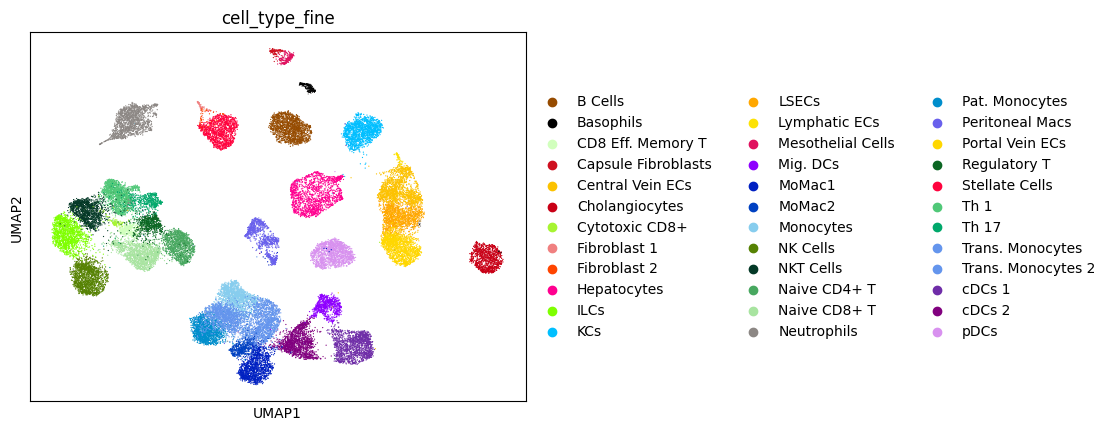

In [16]:
#sc.pp.neighbors(model.mdata['mouse'], use_rep='z_mu')
neighbors_workaround(model.mdata['mouse'], use_rep='z_mu')
sc.tl.umap(model.mdata['mouse'])
sc.pl.umap(model.mdata['mouse'], color='cell_type_fine', palette=palette)

Next we fine-tune by training the target scVI model and aligning the human dataset with this latent representations.

In [18]:
model.train_target(30, save_key='_human')
model.get_representation(eval_model='target', save_libsize=True)

Training on the target dataset for 30 epochs (= 8190 iterations).
Progress: 99.9% - ETA: 0:00:00 - Epoch: 30 - Iteration: 8179 - ms/Iteration: 42.34 - nELBO: 1903.5 (+10.46) - nlog_likeli: 1384.8 (+0.451) - KL-Div z: 13.827 (-0.002) - KL-Div l: 2.8157 (-0.012) - Align-Term: 502.01 (+10.02).           Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/config_dict.pkl
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_config__human.pkl
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_optimizer__human.opt
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_encoder_inner__human.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_encoder_outer__human.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_decoder__human.pth.
Saved /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_lib_encoder

After fine-tuning, we can visualize the aligned latent representation.   

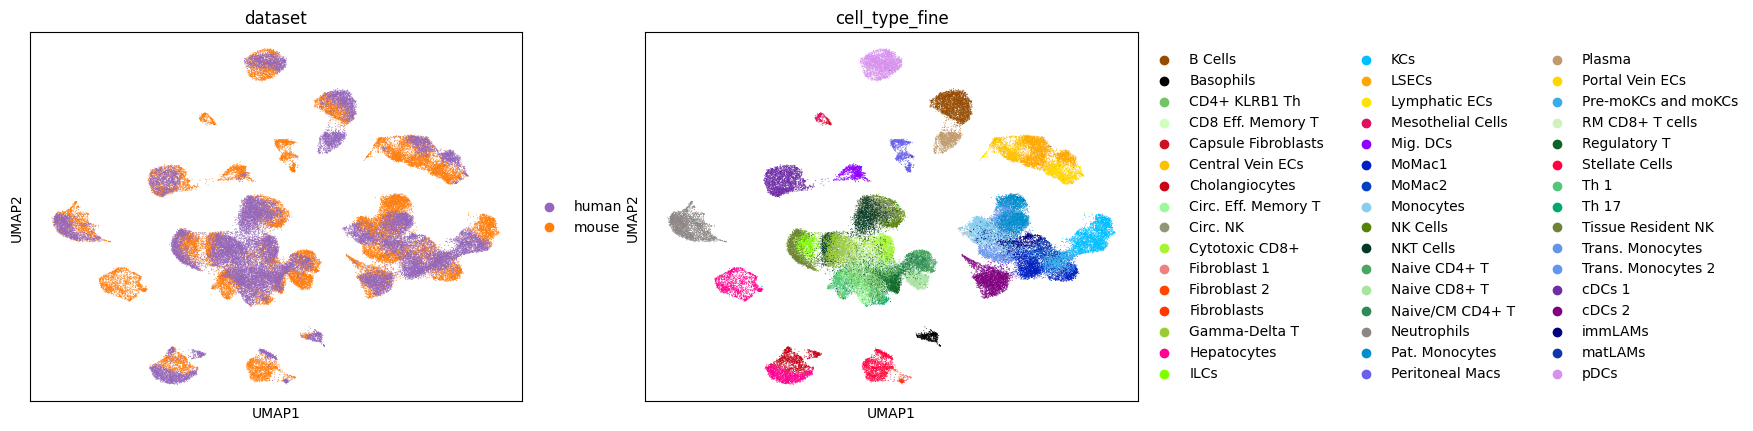

In [19]:
adata_concat.obsm['lat_rep'] = np.concat([mdata.mod['mouse'].obsm['z_mu'], mdata.mod['human'].obsm['z_mu']])

#sc.pp.neighbors(adata_concat, use_rep='lat_rep') 
neighbors_workaround(adata_concat, use_rep='lat_rep')
sc.tl.umap(adata_concat)

sc.pl.umap(adata_concat, color=['dataset', 'cell_type_fine'], palette=palette)

## 2) Information transfer via similarity scores

We continue by evaluating the likelihood based similarity measure between target and context cell types with `return_similarity_df_prot`.   

When `scale=min_max` or `scale=max` the scores are scaled such that the values can be interpreted as 1 = most similar. 
Without scaling the highest values (closest to zero) represent high similarity.
The output dataframe contains target cell types in `df.index` and context cell types in `df.columns`.  
The values should be interpreted row-wise and contain the similarity of a target cell type with the corresponding context cell types.

We can use these similarity scores to match cell type annotation between datasets.
To reduce computational demand reduce the sample size via `max_sample_targ` and `max_sample_cont`.

                     B Cells   Basophils  CD8 Eff. Memory T  \
B Cells            -4.667412 -351.202118        -187.310165   
Basophils        -342.285217   -6.553959        -323.325165   
CD4+ KLRB1 Th    -233.442261 -248.224075         -78.080002   
Central Vein ECs -200.179871 -881.981323        -306.111633   
Cholangiocytes   -219.242920 -664.898621        -577.777588   

                  Capsule Fibroblasts  Central Vein ECs  Cholangiocytes  \
B Cells                   -196.515381       -311.335846     -188.958267   
Basophils                 -243.916443       -286.631592     -258.919800   
CD4+ KLRB1 Th             -135.655609       -246.467194     -215.919586   
Central Vein ECs          -541.279541        -42.993996     -809.694702   
Cholangiocytes            -245.021790       -393.667328      -11.980484   

                  Cytotoxic CD8+  Fibroblast 1  Fibroblast 2  Hepatocytes  \
B Cells              -407.455353   -232.646133   -257.090210  -194.491119   
Basophils       

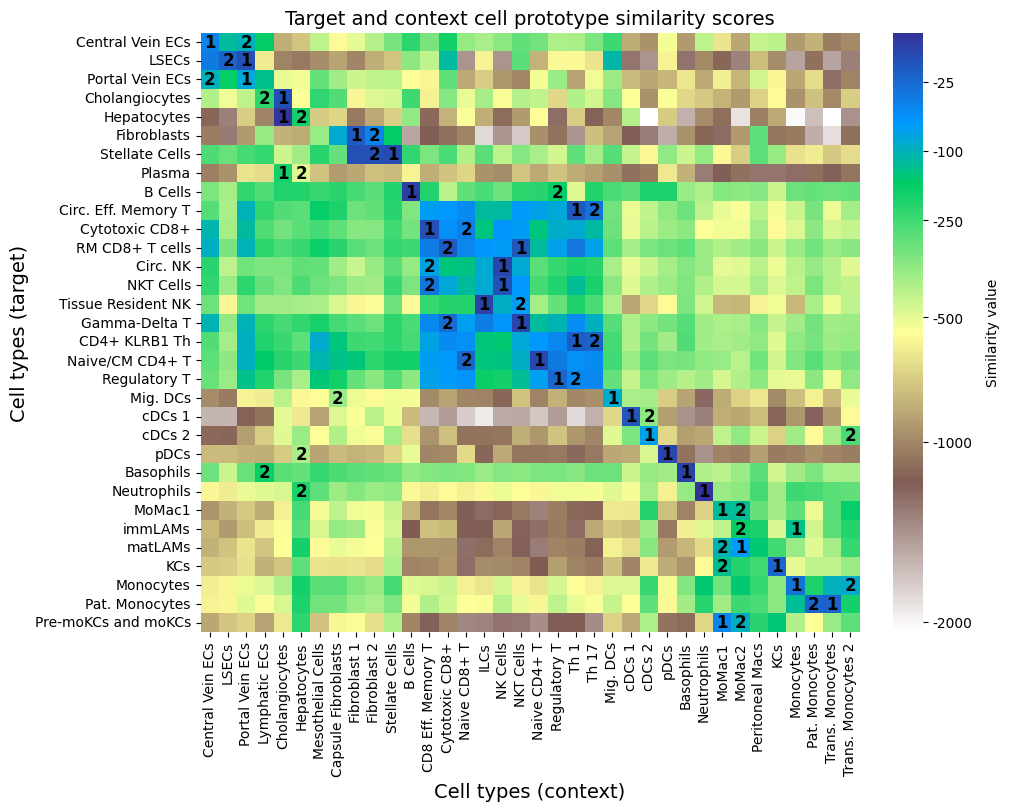

In [20]:
from scspecies.plot import plot_prototype_sim_heatmap

import matplotlib.pyplot as plt
import seaborn as sns

df = model.return_similarity_df()
print(df.head())

plot_prototype_sim_heatmap(df)    

We can use the similarity measure to infer target label annotation from context cells.

We draw a random target cell index and calculate similarity scores for all context cells with `transfer_info`.  
We transfer the context `.obs` labels specified in `context_obs_transfer`.  
The `df_neigbor` dataframe contains all context cells with corresponding indices sorted by similarity.  
The labels can be transferred via majority vote based on the occurence in the top-k most similar cells.  

We can plot the similarity scores for the whole dataset using `plot_similarity`.   
For cell type label coloring refer to the aligned latent space visualization.
Green colors indicate the similar cells while the target cell is marked by a black cross.

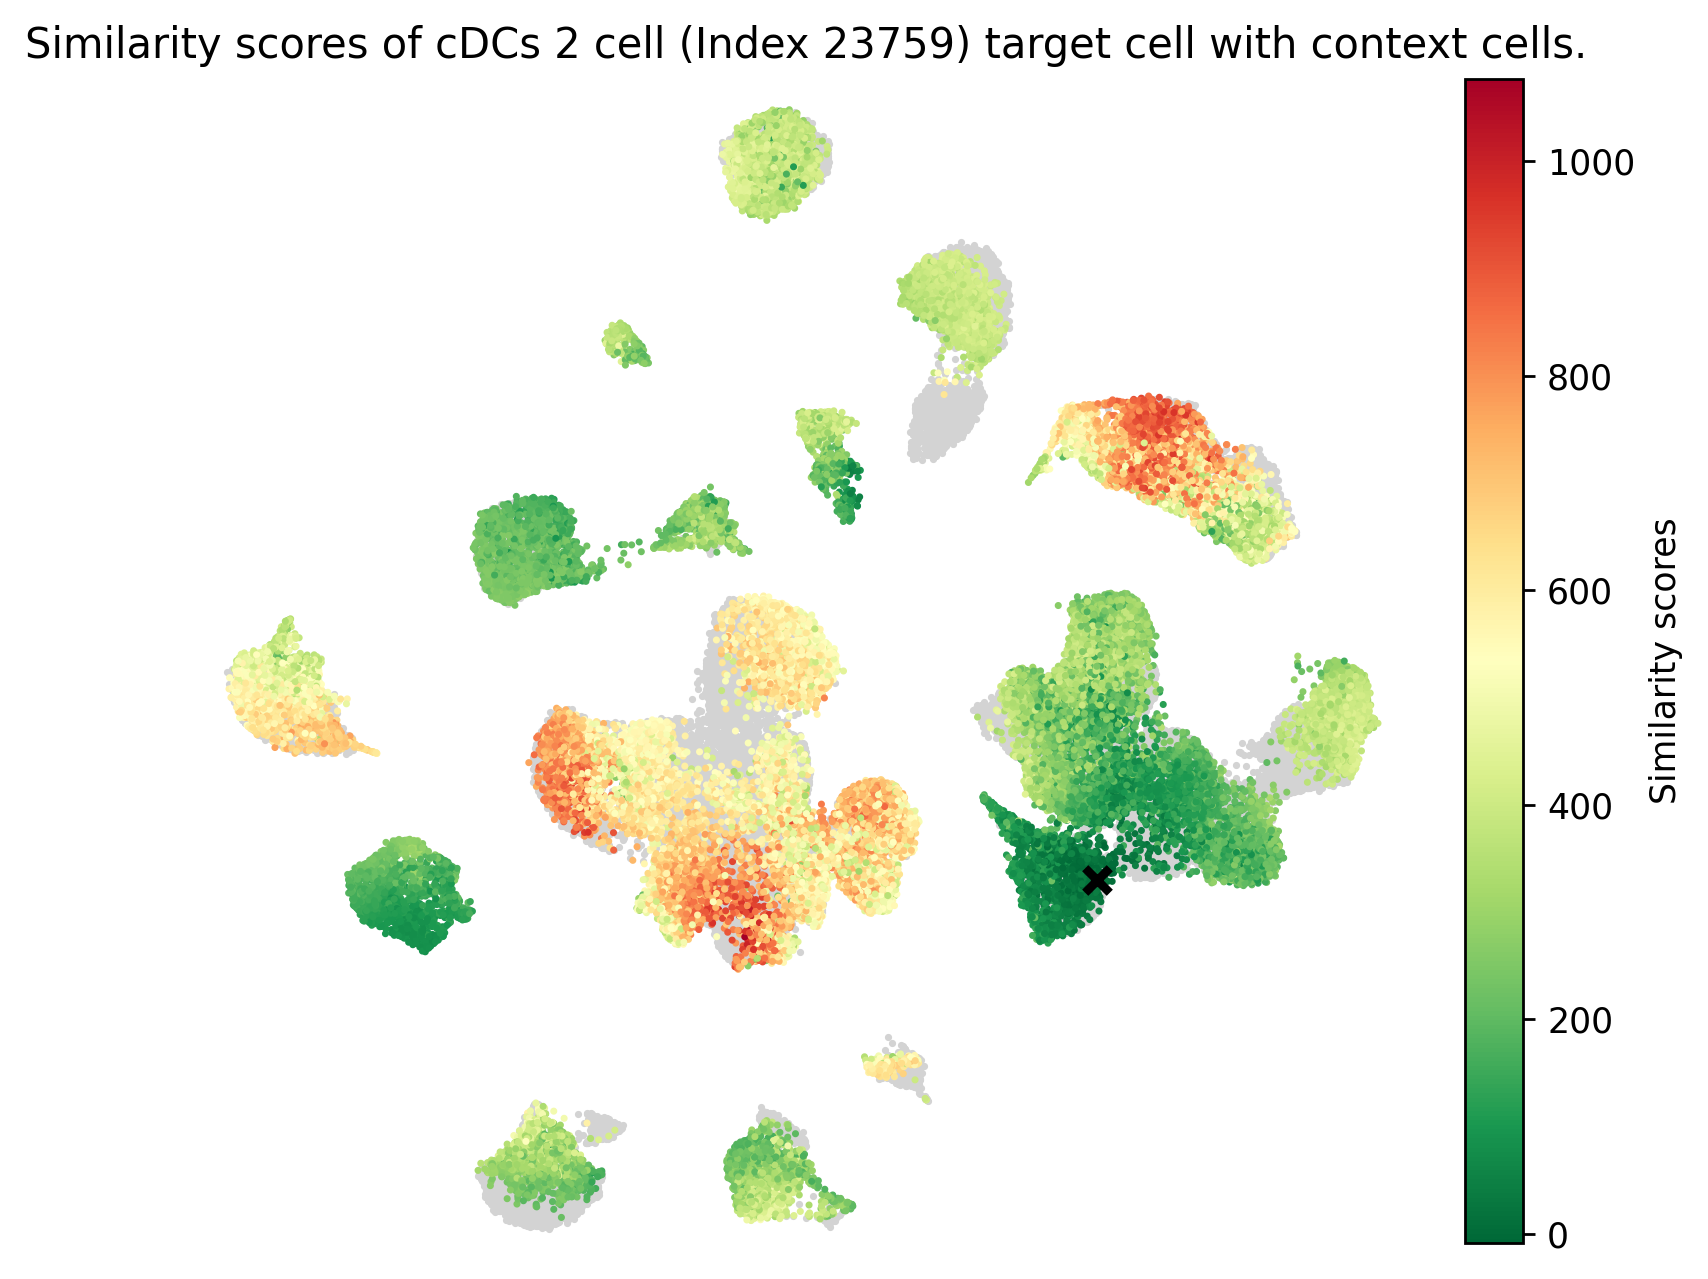

In [21]:
from scspecies.plot import plot_similarity

human_cell_types = model.mdata['human'].obs['cell_type_fine']
mouse_cell_types = model.mdata['mouse'].obs['cell_type_fine']
common_cell_types = np.intersect1d(human_cell_types.unique(), mouse_cell_types.unique())

human_inds = human_cell_types.isin(common_cell_types).to_numpy().nonzero()[0]
human_ind = np.random.choice(human_inds)

context_obs_transfer = ['cell_type_coarse', 'cell_type_fine']
df_neigbor = model.transfer_info(human_ind, context_obs_transfer)

#print('Index of target human cell: {}, Information: {}.'.format(str(human_ind), ', '.join([obs_name+': '+label for label, obs_name in zip(model.mdata['human'].obs[context_obs_transfer].iloc[human_ind].values[0], context_obs_transfer)])))
#print(df_neigbor.head())

plot_similarity(adata_concat, df_neigbor, human_ind)

Next, we perform this process for the whole dataset using `label_transfer`.  
This transfers the specified context labels for the whole dataset and saves the predictions to the `.obs` layer of the target dataset.  
Afterwards, we can compute a normalized confusion matrix (%) and the total balanced accuracy for label transfer with `ret_pred_df`.   
We compare this against the results of the data-level neighbor search.

In [22]:
context_obs_transfer = ['cell_type_coarse', 'cell_type_fine']
model.label_transfer(context_obs_transfer)
#print(model.mdata['human'].obs[['pred_sim_cell_type_coarse', 'cell_type_coarse', 'pred_sim_cell_type_fine', 'cell_type_fine']].head())

df_nns, bas_nns = model.ret_pred_df(pred_key='pred_nns_cell_type_fine', target_label_key='cell_type_fine', context_label_key='cell_type_fine')
df_sim, bas_sim = model.ret_pred_df(pred_key='pred_sim_cell_type_fine', target_label_key='cell_type_fine', context_label_key='cell_type_fine')

#print(df_sim.head())
print('Data-level k=25 nearest neighbor search --> Balanced accuracy: {}%'.format(round(bas_nns*100,2)))
print('Label tarnsfer using similarity measure --> Balanced accuracy: {}%'.format(round(bas_sim*100,2)))

Pre-computing latent space NNS with 250 neighbors using the euclidean distance.
Calculate similarity metric. Step 271/274.

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Data-level k=25 nearest neighbor search --> Balanced accuracy: 59.25%
Label tarnsfer using similarity measure --> Balanced accuracy: 70.35%


We compare the results visually by generateing a bar plot that indicates label transfer improvement over the data level NNS.  
For each target cell type the data NNS accuracy is displayed in the top row and the similarity based label transfer accuracy in the bottom row.  
The improvement in % is displayed at the right.  

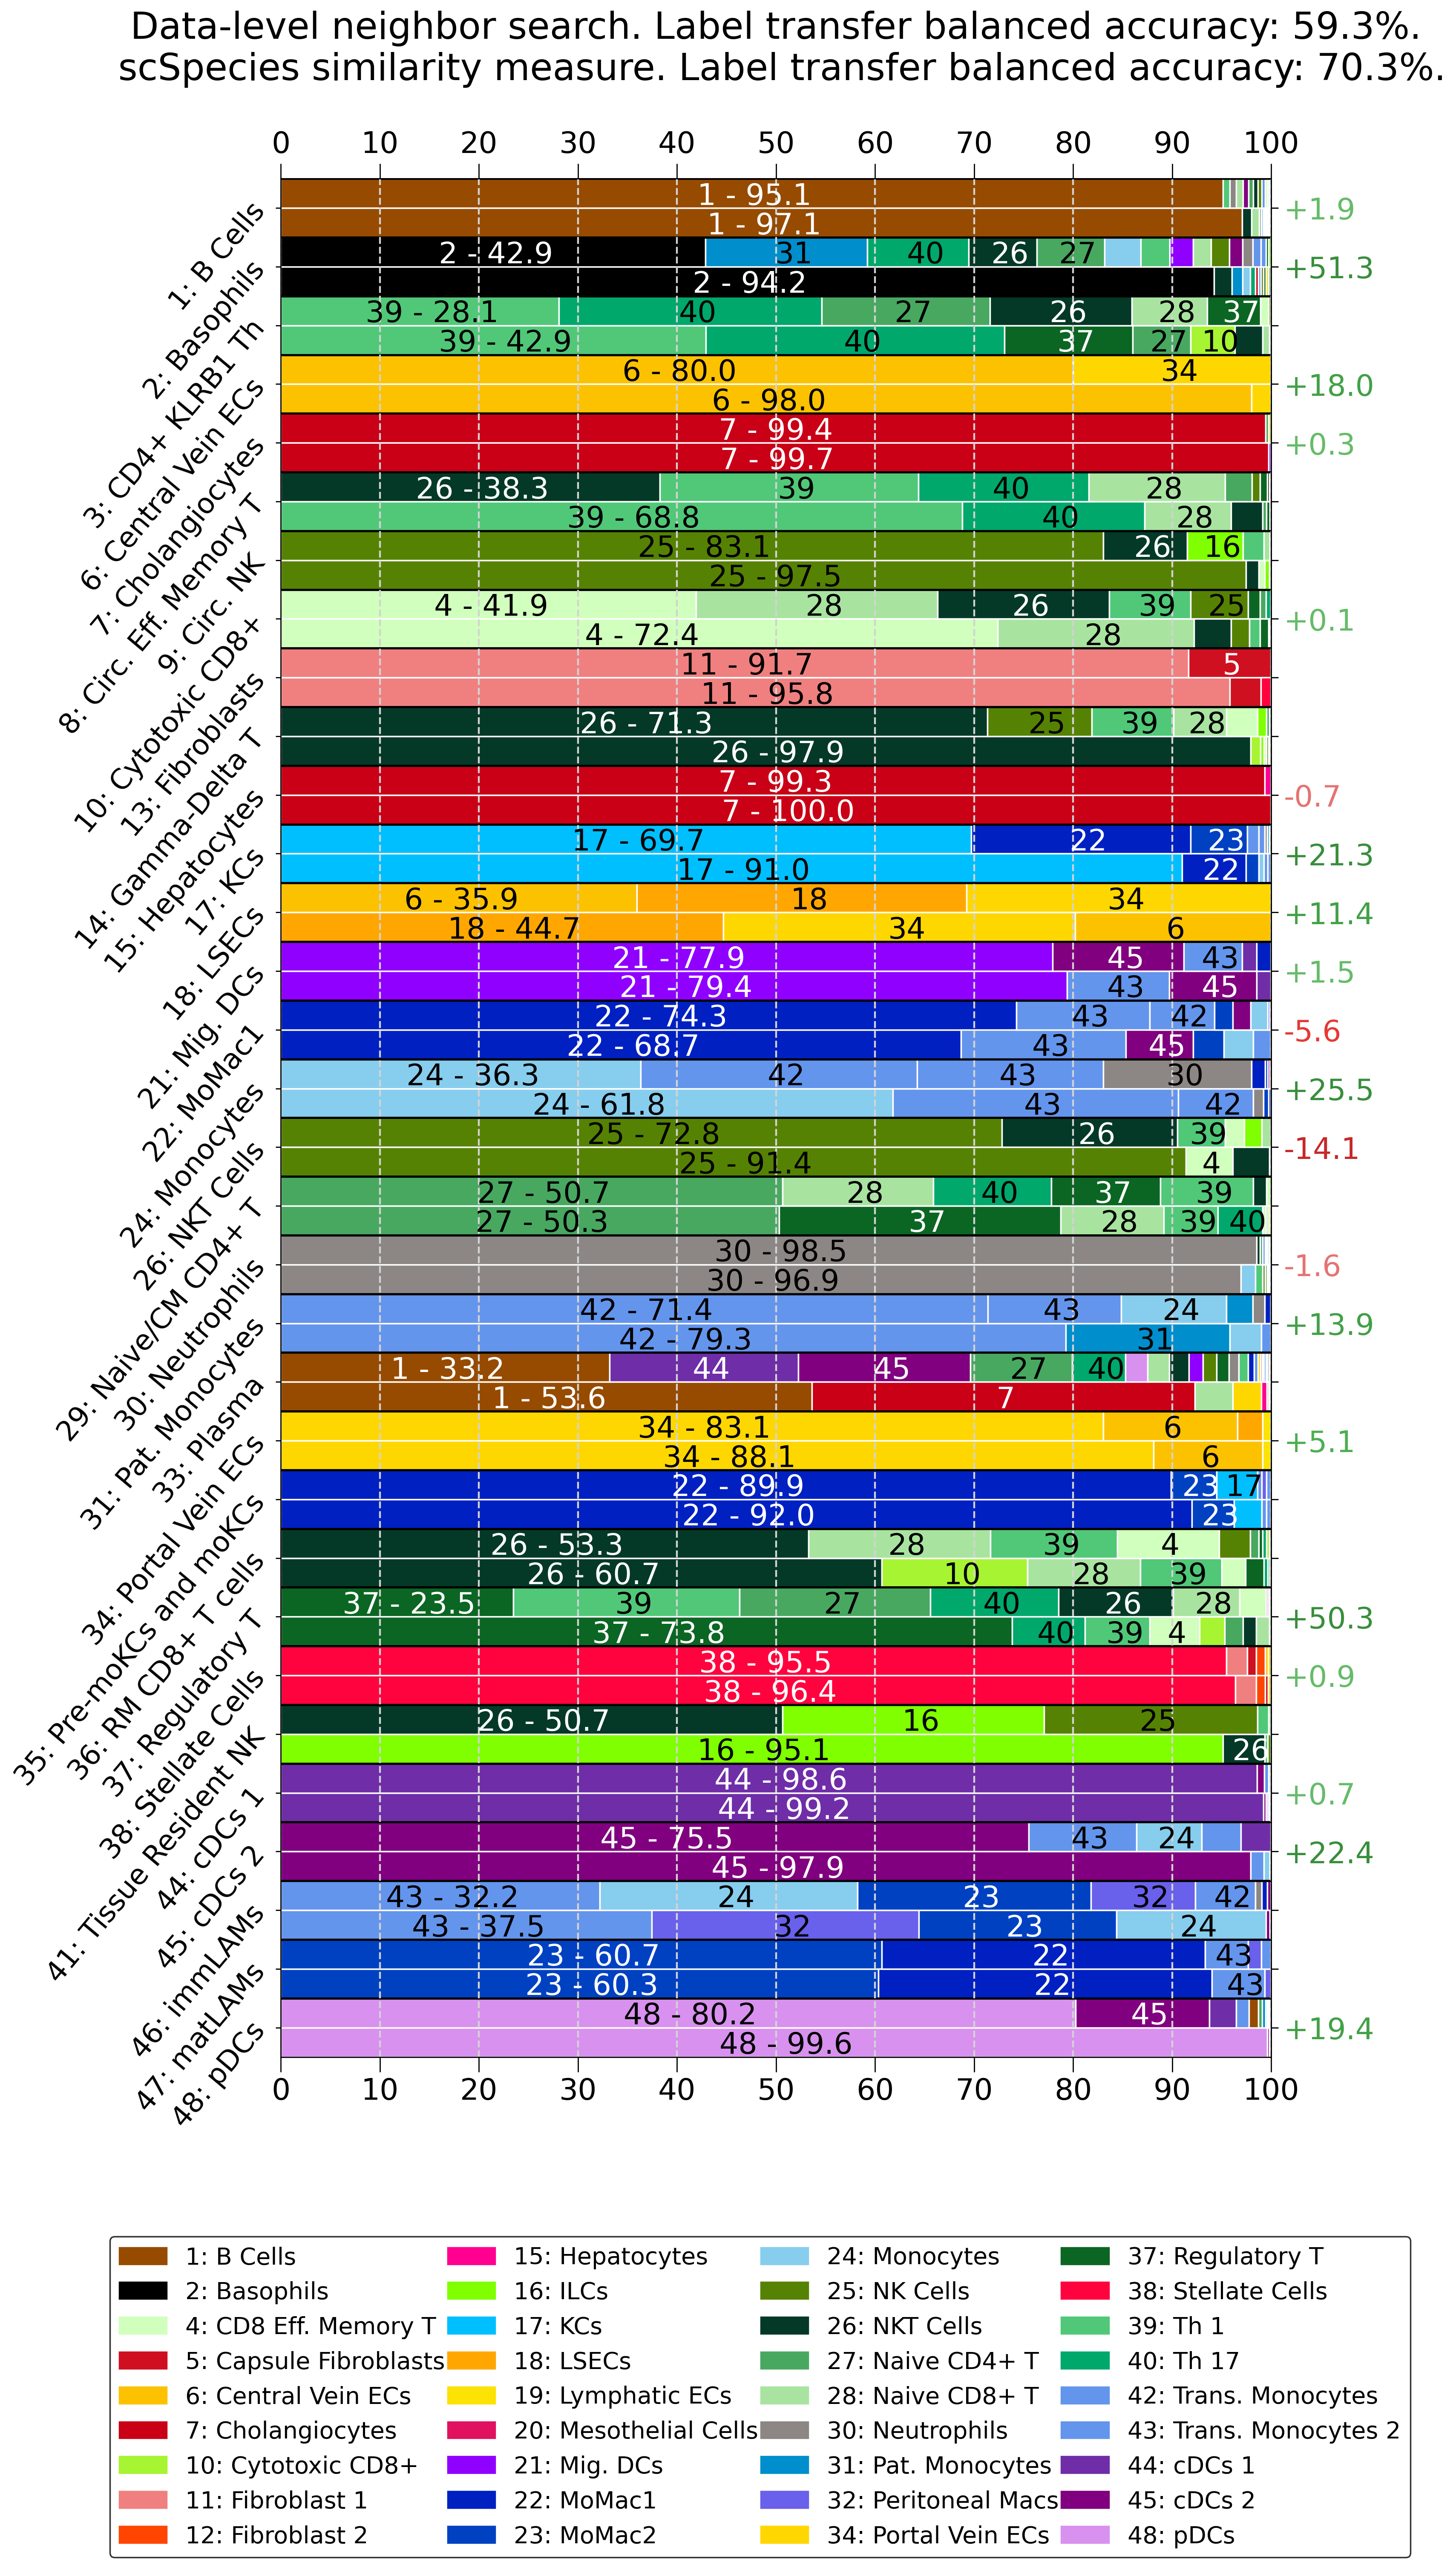

In [23]:
from scspecies.plot import label_transfer_acc

label_transfer_acc(df_nns, df_sim)

## 3) Differential gene expression analysis

The difference in modeled gene expression can be analyzed by comparing the log2-fold change in normalized gene expression with `compute_logfold_change`.  

In [24]:
lfc_dict = model.compute_logfold_change(lfc_delta = 1)

The output is a dictionary with cell type wise data frames containing logfoldchange values and other information.
The dataframes contain the homologous traget gene symbols in their index and their chosen labels as columns. 

- `rho_median_context` : Contains median context normalized gene expression, 
- `mu_median_context` : Contains median context expected value gene expression,  
- `rho_median_target` : Contains median target normalized gene expression,  
- `mu_median_target` : Contains median target expected value gene expression,  
- `lfc` : Contains mMedian Log2 fold-change of the relative expression parameter rho,
- `p` : Probability of Log2 fold-change values greater than `lfc_delta`,
- `lfc_rand` : Contains median Log2 fold-change of the relative expression parameter rho on permuted data,
- `p_rand` : Probability of Log2 fold-change values greater than `lfc_delta` on permuted data. 

In [25]:
print('Results for', list(lfc_dict.keys())[0])
lfc_dict[list(lfc_dict.keys())[0]].head()

Results for B Cells


rho_median_context  mu_median_context  rho_median_target  \
C12orf75        1.244158e-07           0.000183           0.000094   
C1orf21         4.042555e-06           0.005932           0.000009   
C19orf33        2.171564e-05           0.031162           0.000001   
KIAA0513        1.095748e-05           0.015724           0.000009   
C15orf48        1.648087e-07           0.000241           0.000006   

          mu_median_target       lfc         p  lfc_rand    p_rand  
C12orf75          0.140733  6.404266  1.000000  0.879581  0.349972  
C1orf21           0.014045  0.999413  0.500704 -4.610884  1.000000  
C19orf33          0.001948 -3.324667  1.000000 -2.504355  1.000000  
KIAA0513          0.013669 -0.280737  0.002414  0.796202  0.264124  
C15orf48          0.008661  2.525998  1.000000  2.700018  1.000000

We can visualize the results with `plot_lfc` per cell type.

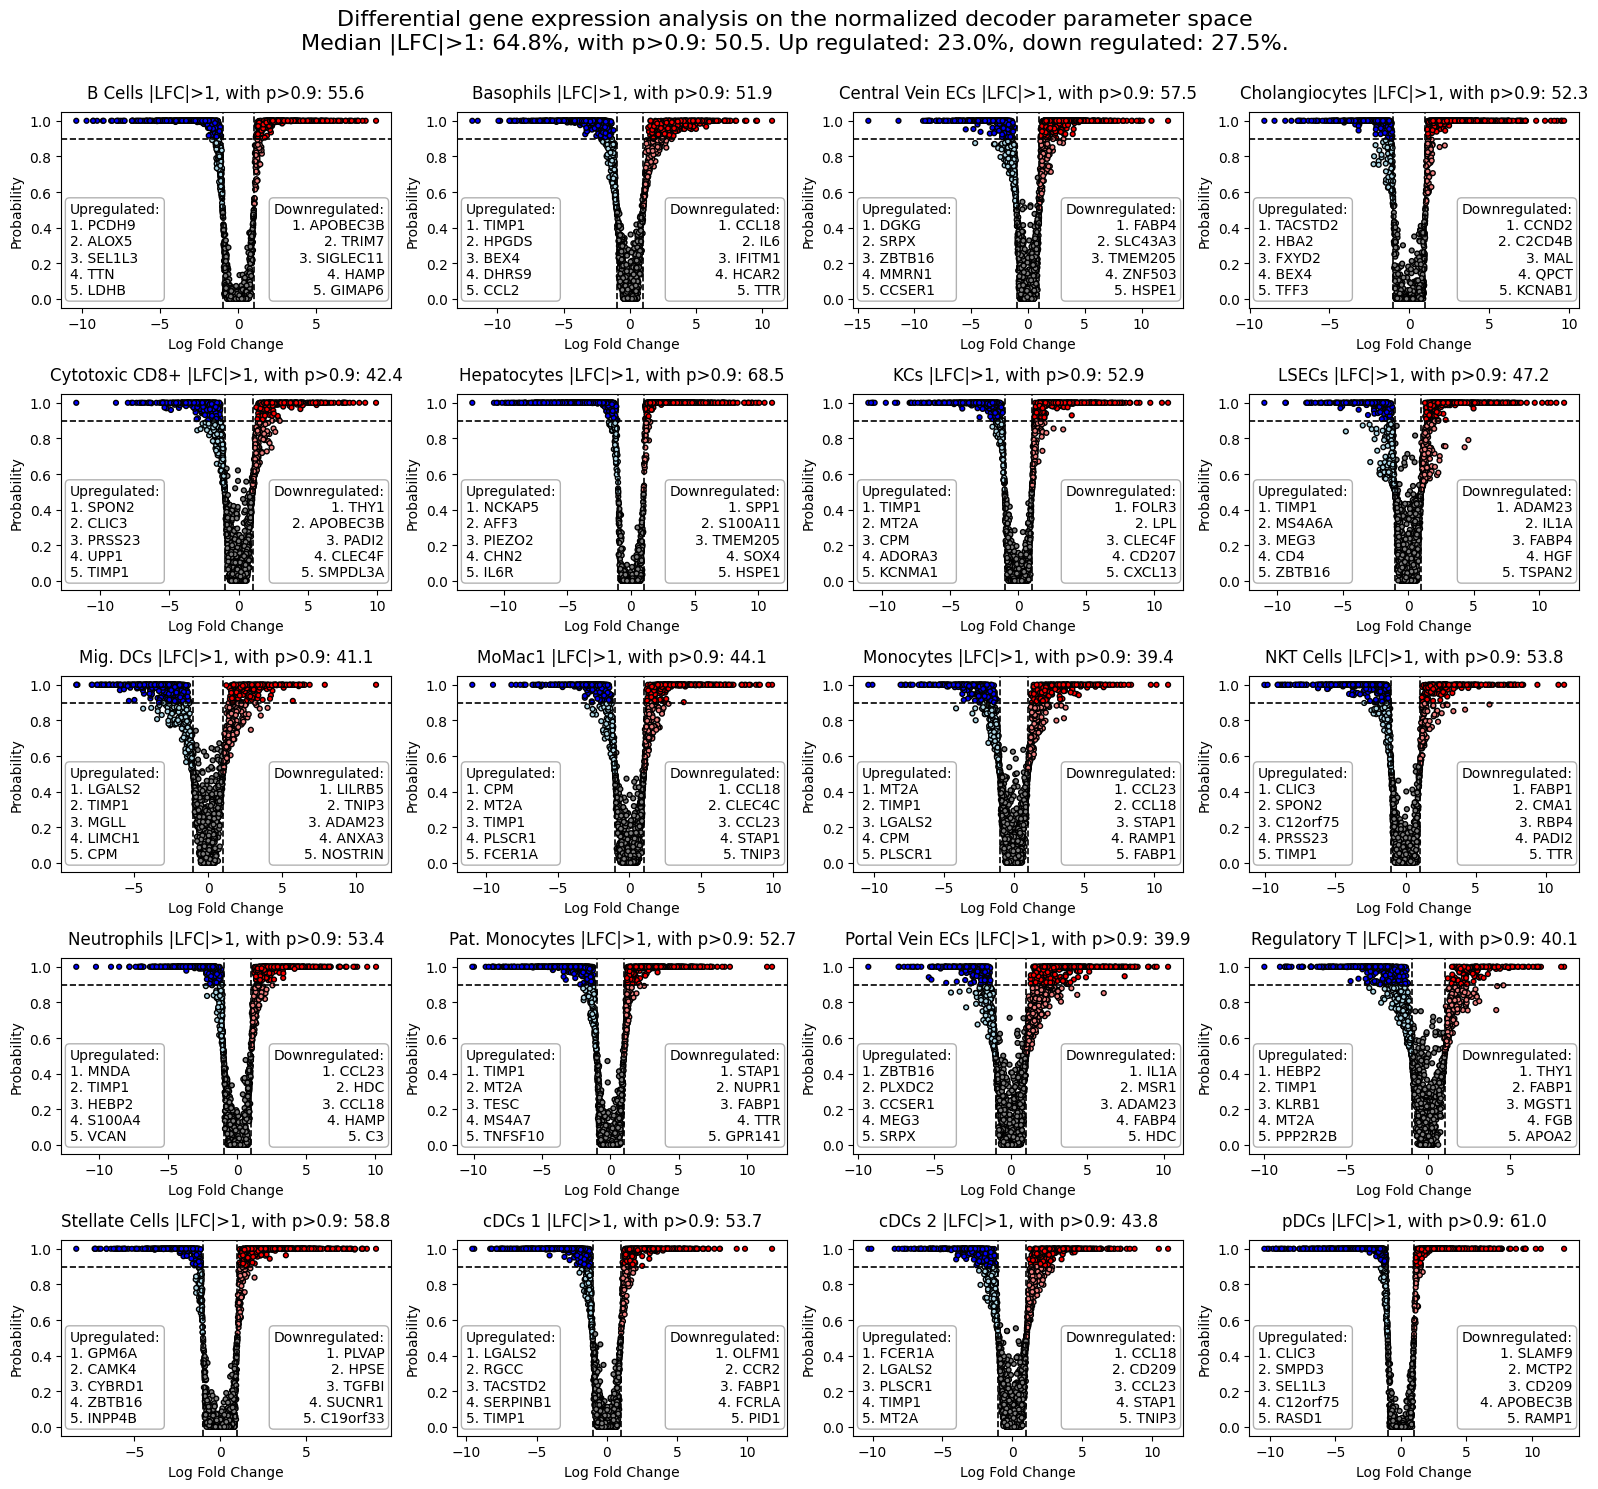

In [26]:
from scspecies.plot import plot_lfc

plot_lfc(lfc_dict)

Lets compare the results with a DFG Analysis at the data level. 
For this we generate homologous cell samples from the latent space.

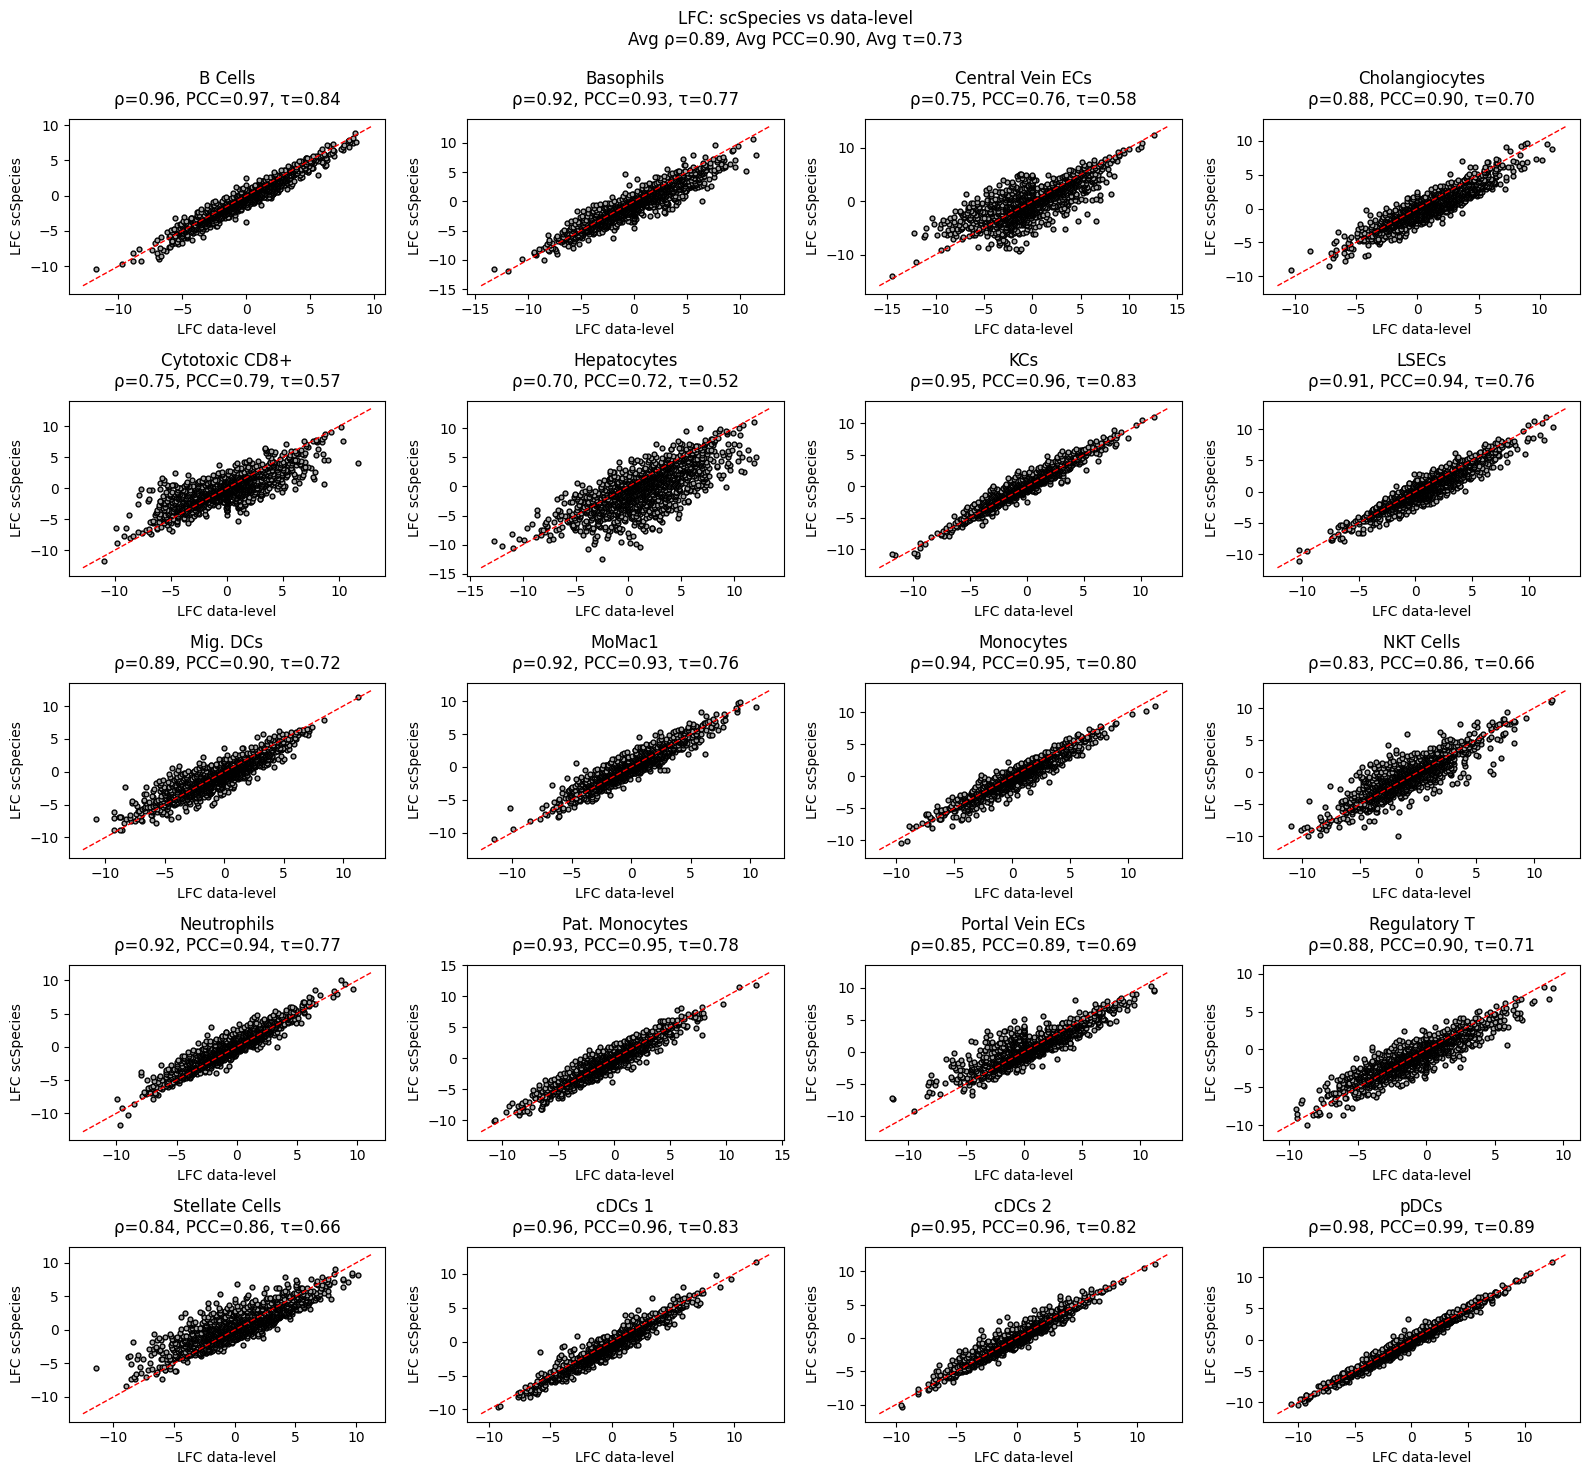

In [29]:
from scspecies.plot import plot_lfc_comparison

target_rho_dict, context_rho_dict = model.generate_homologous_samples(samples=2000)
plot_lfc_comparison(model, lfc_dict)    

We can calculate activity scores for pathways with a downloaded `.gmt` file.  
For demonstartive purposes we provide a manual pathway dictionary.

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/bq/cdql_9s11db1zmbxmw_gz7vw0000gn/T/ipykernel_6592/2528423881.py:22: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_m.concatenate(


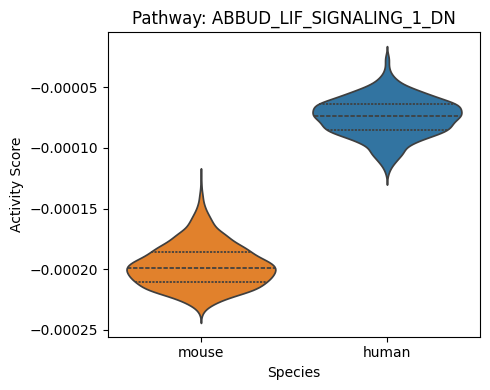

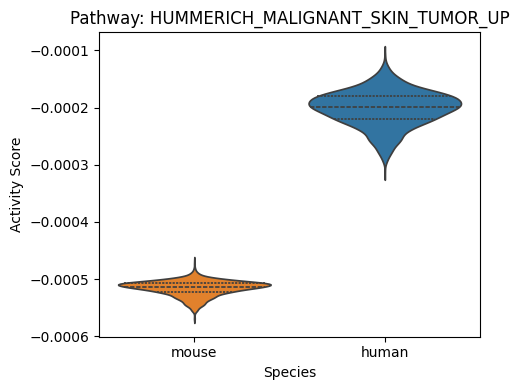

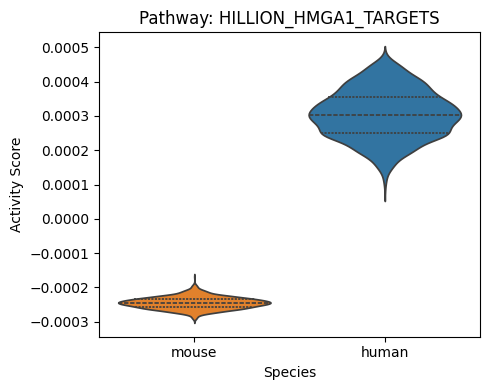

In [30]:
from scspecies.plot import load_and_filter_pathways

plot_cell_type = 'B Cells'

adata_h = ad.concat([ad.AnnData(target_rho_dict[key]) for key in target_rho_dict.keys()])
adata_h.var_names = model.mdata.mod['human'][:, model.target_config['homologous_genes']].var_names
adata_h.obs['cell_type_fine'] = np.concat([[key]*np.shape(target_rho_dict[key])[0] for key in target_rho_dict.keys()])
adata_h.obs_names_make_unique()

adata_m = ad.concat([ad.AnnData(context_rho_dict[key]) for key in context_rho_dict.keys()])
adata_m.var_names = adata_h.var_names
adata_m.obs['cell_type_fine'] = np.concat([[key]*np.shape(context_rho_dict[key])[0] for key in context_rho_dict.keys()])
adata_m.obs_names_make_unique()

#gene_sets_path = '/Users/cschaech/Desktop/scSpecies/dataset/c2.all.v2024.1.Hs.symbols.gmt'
#pathways = load_and_filter_pathways(gene_sets_path, adata_h)

pathways = {'ABBUD_LIF_SIGNALING_1_DN':           ['LIMS1','ITGA6','ENPP2','AHNAK','ALCAM','KLRB1','HK2'],
            'HUMMERICH_MALIGNANT_SKIN_TUMOR_UP':  ['S100A9', 'S100A8', 'LTF', 'CCND1', 'GSTO1','HBA2', 'COL18A1','SLPI','ECM1'],
            'HILLION_HMGA1_TARGETS':              ['CRIP2', 'EDNRB','HSPD1','INSR','GPX3','CXCR4','PMP22','TIMP2','ID2','ID3','MGST1','CD3G','ID1','HSPB1','TFRC','CLU']}

adata = adata_m.concatenate(
    adata_h,
    batch_key="species",
    batch_categories=["mouse", "human"]
)

for key, pathway in pathways.items():
    sc.tl.score_genes(adata, gene_list=pathway, score_name=key)

    adata_plot = adata[adata.obs.cell_type_fine == plot_cell_type]

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.violinplot(
        data=adata_plot.obs,
        x='species',
        y=key,
        hue='species',        
        palette={'mouse':'C1','human':'C0'},
        dodge=False,         
        inner='quartile',
        ax=ax
    )

    ax.set_title(f'Pathway: {key}', fontsize=12)
    ax.set_xlabel('Species')
    ax.set_ylabel('Activity Score')
    plt.tight_layout()
    plt.show()    

Next we use the differentally expressed genes to analyze pathways. As an example we can create ORA Barplots.

- Y-axis: Lists the top five enriched pathways whose member genes are over-represented among the differentially expressed genes.
- X-axis (adj. P-value): Longer bars mean more significant enrichment.

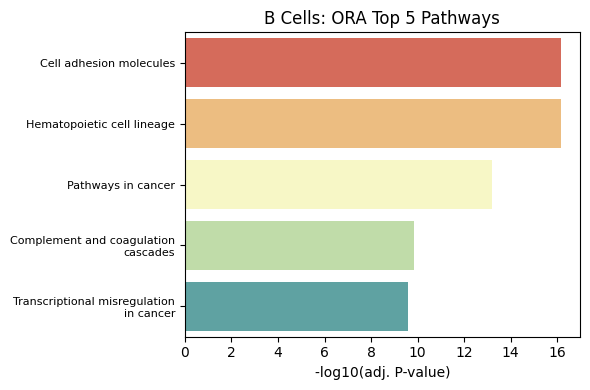

In [31]:
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

cell_type = 'B Cells'
ORA_LIBS = ['KEGG_2021_Human', 'Reactome_Pathways_2024']

df = lfc_dict[cell_type]
degs = df[(df['lfc'].abs() > 1) & (df['p'] > 0.9)]

enr = gp.enrichr(
    gene_list=degs.index.tolist(),
    gene_sets=ORA_LIBS,
    organism='Human',
    outdir=None
)
top5 = enr.results[['Term','Adjusted P-value']].head(5)

wrapped = ["\n".join(textwrap.wrap(t, width=30))
for t in top5['Term']]

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    x = -np.log10(top5['Adjusted P-value']),
    y = wrapped,
    hue     = wrapped,   
    palette = 'Spectral',
    dodge   = False,      
    ax = ax
)

ax.set_title(f'{cell_type}: ORA Top 5 Pathways', fontsize=12)
ax.set_xlabel('-log10(adj. P-value)', fontsize=10)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

We can also plot the GSEA enrichment curves. We plt the pathway that is the most significant hit by FDR.

- X-axis (Rank positions): Genes sorted from highest to lowest log-fold change.
- Running Enrichment Score: Curve rises when a pathway gene is encountered and falls otherwise; the peak ES indicates where pathway members cluster in the ranked list.

/var/folders/bq/cdql_9s11db1zmbxmw_gz7vw0000gn/T/ipykernel_6592/596071678.py:5: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(


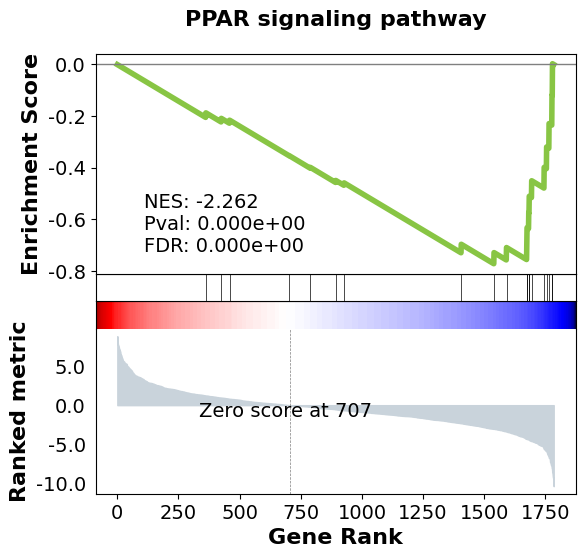

In [32]:
from gseapy.plot import gseaplot

GSEA_LIB = 'KEGG_2021_Human'

pre_res = gp.prerank(
    rnk            = df['lfc'].sort_values(ascending=False),
    gene_sets      = GSEA_LIB,
    processes      = 4,
    permutation_num=100,
    outdir         = None
)

res = pre_res.res2d.sort_values('FDR q-val')
top_term = res.loc[0, 'Term']
rd = pre_res.results[top_term]

ax = gseaplot(
    term        = top_term,
    hits        = rd['hits'],
    nes         = rd['nes'],
    pval        = rd['pval'],
    fdr         = rd['fdr'],
    RES         = rd['RES'],
    rank_metric = pre_res.ranking,
)


## 4) Creating a cell atlas

Finally, we can also create a multi-species cell atlas by aligning a hamster scVI archtecture to the same mouse context model.   
We instantiate a second model and load the encoder parameters of the context encoder.

NOTE: For differential gene expression analysis the context decoder should be retrained.  

In [39]:
model_hamster = scSpecies(device, 
                mdata, 
                path,
                context_key = 'mouse', 
                target_key = 'hamster',                                                   
                )

model_hamster.load('context', save_key='_mouse')

model_hamster.train_target(25, save_key='_hamster')
model_hamster.get_representation(eval_model='target', save_libsize=True)


Initializing context scVI model.
Initializing target scVI model.
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/config_dict.pkl
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_config__mouse.pkl
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_optimizer__mouse.opt
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_encoder_outer__mouse.pth
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_decoder__mouse.pth
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/target_encoder_inner__mouse.pth
Loaded /Users/cschaech/Desktop/scpecies_package/scspecies/tutorials/params/context_lib_encoder__mouse.pth
Training on the target dataset for 25 epochs (= 1150 iterations).
Progress: 99.4% - ETA: 0:00:00 - Epoch: 25 - Iteration: 1143 - ms/Iteration: 38.25 - nELBO: 1747.0 (+9.752) - nlog_likeli: 1255.4 (+2.519) - KL-Div z:

Visualizing the aligned latent space

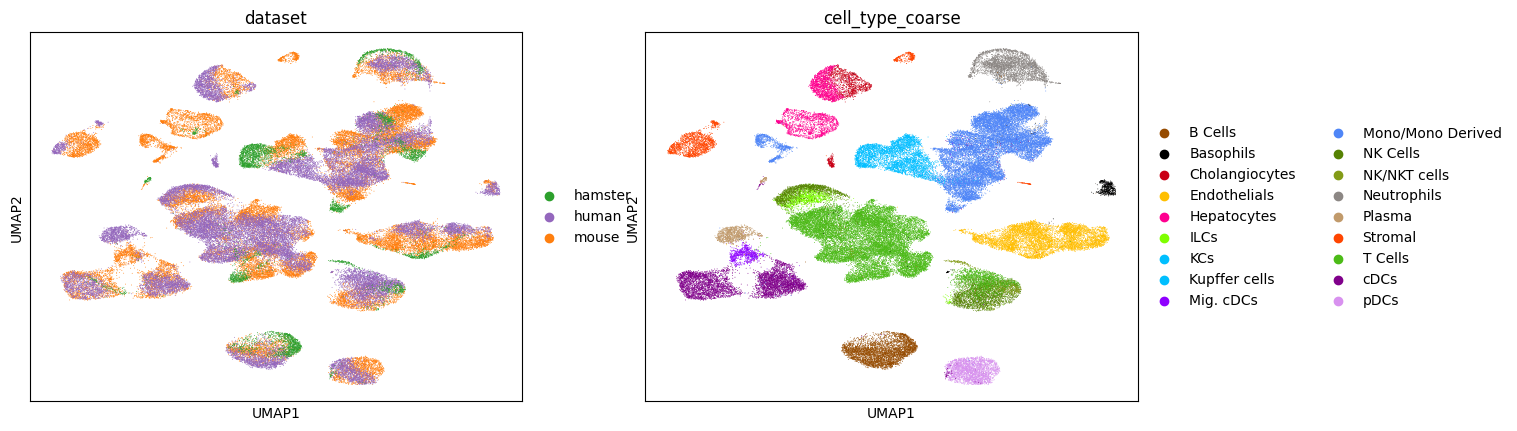

In [40]:
adata_concat = ad.AnnData(
    X=sparse.vstack([mdata.mod['mouse'].obsm['z_mu'], mdata.mod['human'].obsm['z_mu'], mdata.mod['hamster'].obsm['z_mu']]).toarray(),
    obs=pd.concat([mdata.mod['mouse'].obs[['dataset', 'cell_type_coarse']], mdata.mod['human'].obs[['dataset', 'cell_type_coarse']], mdata.mod['hamster'].obs[['dataset', 'cell_type_coarse']]])
)

# Color scheme for the liver cell dataset. Won't return nice results for other datasets.
palette = return_palette(list(adata_concat.obs.cell_type_coarse.unique()) + list(adata_concat.obs.dataset.unique()))

sc.pp.pca(adata_concat) 
neighbors_workaround(adata_concat, use_rep='X_pca')
sc.tl.umap(adata_concat)

sc.pl.umap(adata_concat, color=['dataset', 'cell_type_coarse'], palette=palette)